# IMPORTS

In [1]:
import numpy as np
import sys
import math
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from collections import Counter
from NoteBookUtilities.read_data import get_seq_indexes
from pathlib import Path
import torch
from torch.nn.utils.rnn import pad_sequence
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

### SETTING SEEDS ###
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "Data"  
DATASET_DIR = DATA_DIR / "Datasets"
RESULTS_DIR = ROOT_DIR / "Results"
BEPIPRED2_DATA = ROOT_DIR / "Data" / "BepiPred2Data"
BEPIPRED3_DATA = ROOT_DIR / "Data" / "BepiPred3Data"


### VARIABLES ###
one_hot_encoding_dict = {"A":0, "C":1, "M":2, "N":3, "D":4, "P":5, "E":6,
                        "F":7, "Q":8, "R":9, "G":10, "H":11, "I":12, "K":13,
                        "L":14, "S":15, "T":16, "V":17, "W":18, "Y":19, "-":20}  #Encode AA + padding token

# FUNCTIONS

In [13]:

def get_stats_from_fasta_file(infile_path, amino_acids):
    #get binary sequence indices
    infile = open(infile_path, 'rb')
    
    whole_file = infile.read()
    seq_start_ends = get_seq_indexes(whole_file)
    all_sequences = ""
    #amino acids + X (DNA, RNA or augmented AA)
    sequence_lengths = list()
    linear_epitope_lengths = list()
    epitopes_per_sequences = list()
    
    #go through each sequence and create all window_sized sequences
    for seq_start_end in seq_start_ends:
        seq_start = seq_start_end[0]
        seq_end = seq_start_end[1]
        start_read = infile.seek(seq_start)
       
        input_sequence = infile.read(seq_end - seq_start).decode("utf-8") 
    
        linear_epitope_count = 0
        epitopes_per_sequence = 0
        for aa in input_sequence:
            #if there is an epitope, start counting epitope length
                if aa in amino_acids:
                    linear_epitope_count += 1
                    epitopes_per_sequence += 1
                #reset counting
                elif aa not in amino_acids and linear_epitope_count != 0:
                    linear_epitope_lengths.append(linear_epitope_count)
                    linear_epitope_count = 0
                else:
                    pass
                
        epitopes_per_sequences.append(epitopes_per_sequence)
        sequence_lengths.append( len(input_sequence) )
        all_sequences += input_sequence
    
    #count non-epitope and epitope AA's.  
    aa_count_dict = Counter(all_sequences)
    sequence_length_count_dict = Counter(sequence_lengths)
    linear_epitope_length_count_dict = Counter(linear_epitope_lengths)
    
    sequence_length_avg = 0
    num_of_seqs = 0
    for sequence_length, sequence_length_count in sequence_length_count_dict.items():
        sequence_length_avg += sequence_length*sequence_length_count
        num_of_seqs += sequence_length_count
    print(f"Average sequence length {sequence_length_avg / num_of_seqs}")
    print(f"Average number of epitopes per sequence {sum(epitopes_per_sequences) / len(epitopes_per_sequences)}")
    
    infile.close()
    
    return aa_count_dict, sequence_length_count_dict, linear_epitope_length_count_dict


def epitope_aa_distribution_barplot(amino_acids, aa_counts, save_file):
    """
    Inputs: AA_counts. A Counter object containing amino acid counts for non-epitopes and epitopes.
            save_results_dir. Path to to directory to save the image. Default is to save to current working directory. 
    Output: Barplot
    """
    
    fig = plt.subplots(figsize =(10, 6))
    width = 0.3
    opacity = 0.6
    labels = ["BP2", "BP2HR", "BP3", "BP3HR", "BP3C50ID"]
    width = 0.15
    colors = [( (234/255, 15/255, 15/255), (234/255, 97/255, 15/255) ),
              ((10/255, 110/255, 36/255), (10/255, 197/255, 60/255)),
             ((13/255, 102/255, 242/255), (13/255, 230/255, 242/255)),
             ((139/255, 13/255, 242/255), (242/255, 13/255, 235/255)),
             ((242/255, 196/255, 13/255), (242/255, 231/255, 13/255))]
    #(red, orange), (dark green, light green), (dark blue, cyan), (purple, pink), (dirty yellow, yellow)
#    amino_acid_tick_labels = [f"{amino_acids[i]}\n"+str(round(aa_freqs[i],3)) for i in range(num_of_aa) ]
    
    #go through counts of each aa_counts dict
    for i in range (len(aa_counts)):
        aa_count = aa_counts[i]
        num_of_aa = len(amino_acids)
        non_epitope_counts = [aa_count[aa.lower()] for aa in amino_acids ]
        epitope_counts = [aa_count[aa] for aa in amino_acids]
        total_counts = [non_epitope_counts[i] + epitope_counts[i] for i in range( len(amino_acids) )]
        epi_freqs = list()
#        non_epi_freqs = list()
        aa_freqs = list()
        kl_divergences = list()
        
        print(f"{labels[i]}")
        print(f"Overall epitope frequency {sum(epitope_counts) / sum(total_counts) } ")
        for j in range(num_of_aa):
            aa_freq = total_counts[j] / sum(total_counts)
#            epi_freq = epitope_counts[j] / total_counts[j] #frequency relative to non-epitope and epitope of same AA
            epi_freq = epitope_counts[j] / sum(epitope_counts) #frequency relative to epitopes of all other AA
#            epi_freqs.append(epi_freq)
#            non_epi_freqs.append(1 - epi_freq)
#            aa_freqs.append(aa_freq)
            kl_divergence = epi_freq*math.log(epi_freq/aa_freq)
            kl_divergences.append(kl_divergence)
    
       
            print(f"{amino_acids[j]} epitope frequency: {round(epi_freq*100, 3)}% . AA frequency: {round(aa_freq*100, 3)}%")
        
        idx = np.arange(num_of_aa)
        idx = [x + width*i for x in idx]
        barplot1 = plt.bar(idx, kl_divergences, width, color=colors[i][0], alpha = opacity, label=labels[i])
        
#        barplot2 = plt.bar(idx, epitope_counts, width, bottom=non_epitope_counts, color=colors[i][1], alpha = opacity)
#        barplot1 = plt.bar(idx, non_epi_freqs, width, color=colors[i][0], alpha = opacity, label=labels[i])
#        barplot2 = plt.bar(idx, epi_freqs, width, bottom=non_epi_freqs, color=colors[i][1], alpha = opacity)
        
        # Add epitope frequency above bars
#        for k in range(num_of_aa):
#            height = barplot1[k].get_height() + barplot2[k].get_height()
#            plt.text(barplot1[k].get_x() + barplot1[k].get_width(), height,
#                     f"{round(epi_freqs[k],3)}", ha='center', va='bottom', fontsize=6.5)
    
    plt.ylabel("KL divergence")
    plt.title("Epitope residue KL-divergence")
    plt.xticks(idx,  amino_acids)
    plt.grid()
    plt.xlabel("Amino acids")
#    plt.yticks(np.arange(0, , ))
    plt.legend()
    
    save_path = save_file.parent
    file_name = save_file.name
    try:
        save_path.mkdir(parents=True, exist_ok=False)
    except FileExistsError:
        print("Save directory was already there. Saving it there.")
    else:
        print("Save directory not found. Made new one. ")
        
    plt.savefig(save_path / f"{file_name}", dpi = 600)
    plt.show()

def combined_linear_epitope_length_barplot(linear_epitope_length_count_dicts, save_file):
    
    labels = ["BP2", "BP2HR", "BP3", "BP3HR", "BP3C50ID"]
    colors = colors = [(234/255, 15/255, 15/255), (10/255, 110/255, 36/255), (13/255, 102/255, 242/255),
                       (139/255, 13/255, 242/255), (242/255, 196/255, 13/255)]
    width = 0.17
    opacity = 0.6
    all_linear_epi_lengths = list()
    
    for i in range (len(linear_epitope_length_count_dicts)):    
        linear_epitope_length_count_dict = linear_epitope_length_count_dicts[i]
        
        linear_epitope_length_avg = 0
        linear_epitope_lengths = list()
        linear_epitope_length_counts = list()
        
        for linear_epitope_length, linear_epitope_length_count in linear_epitope_length_count_dict.items():
            #not considerning epitopes of length 1 as a linear epitope when computing avg. linear epitope length
            if linear_epitope_length != 1:
                linear_epitope_lengths.append(linear_epitope_length)
                linear_epitope_length_counts.append(linear_epitope_length_count)
                linear_epitope_length_avg += linear_epitope_length*linear_epitope_length_count
        
        linear_epitope_length_avg = linear_epitope_length_avg / sum(linear_epitope_length_counts)
        print(f"Average linear epitope length {linear_epitope_length_avg}")
        
        all_linear_epi_lengths.extend(linear_epitope_lengths)
    
    #add epitopes of length 1 for bar plot
    all_linear_epi_lengths.append(1)
    all_linear_epi_lengths = set(all_linear_epi_lengths)
    
    fig = plt.subplots(figsize =(11, 6))
    
    for i in range (len(linear_epitope_length_count_dicts)):
        
        linear_epitope_length_count_dict = linear_epitope_length_count_dicts[i]
        linear_epitope_lengths = linear_epitope_length_count_dict.keys()
        
        for epi_len in all_linear_epi_lengths:
            if epi_len not in linear_epitope_lengths:
                 linear_epitope_length_count_dict[epi_len] = 0
        
        linear_epitope_lengths = list()
        linear_epitope_length_counts = list()
        for linear_epitope_length, linear_epitope_length_count in linear_epitope_length_count_dict.items():
            linear_epitope_lengths.append(linear_epitope_length)
            linear_epitope_length_counts.append(linear_epitope_length_count)
        
        total_counts = sum(linear_epitope_length_counts)
        print(f"{labels[i]} Total number of epitopes {total_counts}")
        sorted_length_and_counts = sorted(zip(linear_epitope_lengths, linear_epitope_length_counts), key=lambda pair: pair[0])
        
        linear_epitope_lengths = [j[0] for j in sorted_length_and_counts]
        linear_epitope_length_counts = [j[1] for j in sorted_length_and_counts]
        linear_epitope_length_ratios = [j[1]/total_counts for j in sorted_length_and_counts]
        
        
        print(f"Epitope length and counts:  {sorted_length_and_counts}")

        idx = np.arange(len(linear_epitope_lengths))
        idx = [x + width*i for x in idx]
#        plt.bar(idx, linear_epitope_length_counts, width, color=colors[i], alpha = opacity, label=labels[i])
        plt.bar(idx, linear_epitope_length_ratios, width, color=colors[i], alpha = opacity, label=labels[i])
    
    idx = np.arange(len(linear_epitope_lengths))
    plt.xlabel("Linear epitope lengths")
    plt.ylabel("Linear epitope length count ratio")
    plt.xticks(idx, linear_epitope_lengths)
    plt.yticks(np.arange(0, 0.56, 0.05))
    plt.grid()
    plt.title("Linear epitope length count ratios of epitope annotated datasets")
    plt.legend()
    
    save_path = save_file.parent
    file_name = save_file.name
    try:
        save_path.mkdir(parents=True, exist_ok=False)
    except FileExistsError:
        print("Save directory was already there. Saving it there.")
    else:
        print("Save directory not found. Made new one. ")
        
    plt.savefig(save_path / f"{file_name}", dpi = 600)
    plt.show()

    
def sequence_length_barplot(sequence_length_dicts, save_file):
    """
    
    """
    labels = ["BP2", "BP2HR", "BP3", "BP3HR", "BP3C50ID"]
    colors = colors = [(234/255, 15/255, 15/255), (10/255, 110/255, 36/255), (13/255, 102/255, 242/255),
                       (139/255, 13/255, 242/255), (242/255, 196/255, 13/255)]
    width = 0.17
    opacity = 0.6
    
    bin_arr = np.arange(50, 1051, 50)
    nr_of_bins = len(bin_arr)
#    bin_labels = ["0-50"]
#    bin_labels.extend([str(bin_arr[i])+"-"+str(bin_arr[i+1]) for i in range(nr_of_bins - 1)])
    bin_found = False
    fig = plt.subplots(figsize =(11, 6))
    
    for i in range(len(sequence_length_dicts)):
        sequence_length_dict = sequence_length_dicts[i]
        
        #initialize count_dict
        bin_count_dict = {}
        for bin_val in bin_arr:
            bin_count_dict[bin_val] = 0
        
        bin_count_dict[40] = 0 

        for sequence_length, sequence_length_count in sequence_length_dict.items():
            
            #find bin for sequence length
            for j in range(nr_of_bins - 1):
                if sequence_length >= bin_arr[j] and sequence_length < bin_arr[j+1]:
                    bin_to_put_in = bin_arr[j]
                    bin_found = True
                    break
            if not bin_found:
                print(sequence_length)
                bin_count_dict[40] = bin_count_dict[40] + sequence_length_count 
            else:
                bin_count_dict[bin_to_put_in] = bin_count_dict[bin_to_put_in] + sequence_length_count 
            
            bin_found = False
        
        bins_and_bin_counts = [(bins, bin_counts) for bins, bin_counts in bin_count_dict.items()]
        bins_and_bin_counts = sorted(bins_and_bin_counts, key=lambda pair: pair[0])
        bins = [val[0] for val in bins_and_bin_counts]
        bin_counts = [val[1] for val in bins_and_bin_counts]
        all_counts = sum(bin_counts)
        bin_ratios = [val / all_counts for val in bin_counts]
        #remove last bin (1050-1100)
        bins = bins[:-1]
        bin_counts = bin_counts[:-1]
        bin_ratios = bin_ratios[:-1]
        
        idx = np.arange(len(bins))
        idx = [x + width*i for x in idx]
#        plt.bar(idx, bin_counts, width, color=colors[i], alpha = opacity, label=labels[i])
        plt.bar(idx, bin_ratios, width, color=colors[i], alpha = opacity, label=labels[i])
        
    print(bins)
    idx = np.arange(len(bins))
    plt.xlabel("Sequence length")
#    plt.ylabel("Sequence length counts")
    plt.ylabel("Sequence length count ratios")
    plt.xticks(idx, bins)
    plt.grid()
#    plt.yticks(np.arange(0, 151, 5))
    plt.yticks(np.arange(0, 0.31, 0.05))
#    plt.title("Sequence length counts of epitope annotated datasets")
    plt.title("Sequence length count ratios of epitope annotated datasets")
    plt.legend()
    
    save_path = save_file.parent
    file_name = save_file.name
    try:
        save_path.mkdir(parents=True, exist_ok=False)
    except FileExistsError:
        print("Save directory was already there. Saving it there.")
    else:
        print("Save directory not found. Made new one. ")
        
    plt.savefig(save_path / f"{file_name}", dpi = 600)
    plt.show()
    

def read_accs_and_sequences_from_fasta(infile):
    """
    Input: readfile: Fasta file. 
    Outputs: pdb_accs_and_sequences: List of tuples. Containing accs and sequences, e.g. [(acc, aTHNtem..)..()]. 
    """
    pdb_accs = list()
    sequences = list()
    seq = ""
    read_pdb_acc = False
    
    if not infile.is_file():
        print(f"The input file was invalid. Invalid file was {infile}")
        
    infile = open(infile, "r")
    readfile = infile.readlines()
    infile.close()

    for line in readfile:
        line = line.strip()
        if line.startswith(">"):
            pdb_acc = line.split(">")[1]
            if read_pdb_acc:
                pdb_accs.append(pdb_acc)
                sequences.append(seq)
                #reset sequence string
                seq = ""
            #catch first pdb accesion. First pdb acc is unique
            else:
                pdb_accs.append(pdb_acc)
        else:
            seq += line
            read_pdb_acc = True

    #get last sequence
    sequences.append(seq)
    pdb_accs_and_sequences = tuple( zip(pdb_accs, sequences) )
    return pdb_accs_and_sequences

# Data analysis

Average sequence length 222.1244635193133
Average number of epitopes per sequence 23.042918454935624
Average sequence length 231.98918918918918
Average number of epitopes per sequence 23.951351351351352
Average sequence length 213.5807560137457
Average number of epitopes per sequence 24.8127147766323
Average sequence length 224.24804177545693
Average number of epitopes per sequence 25.702349869451698
Average sequence length 238.3935860058309
Average number of epitopes per sequence 31.606413994169095
BP2
Overall epitope frequency 0.10373876920104337 
L epitope frequency: 6.184% . AA frequency: 8.743%
G epitope frequency: 6.426% . AA frequency: 7.168%
A epitope frequency: 4.526% . AA frequency: 6.355%
V epitope frequency: 4.768% . AA frequency: 6.896%
S epitope frequency: 6.985% . AA frequency: 7.023%
I epitope frequency: 4.917% . AA frequency: 5.584%
T epitope frequency: 6.091% . AA frequency: 5.99%
E epitope frequency: 7.432% . AA frequency: 6.025%
F epitope frequency: 3.651% . AA freq

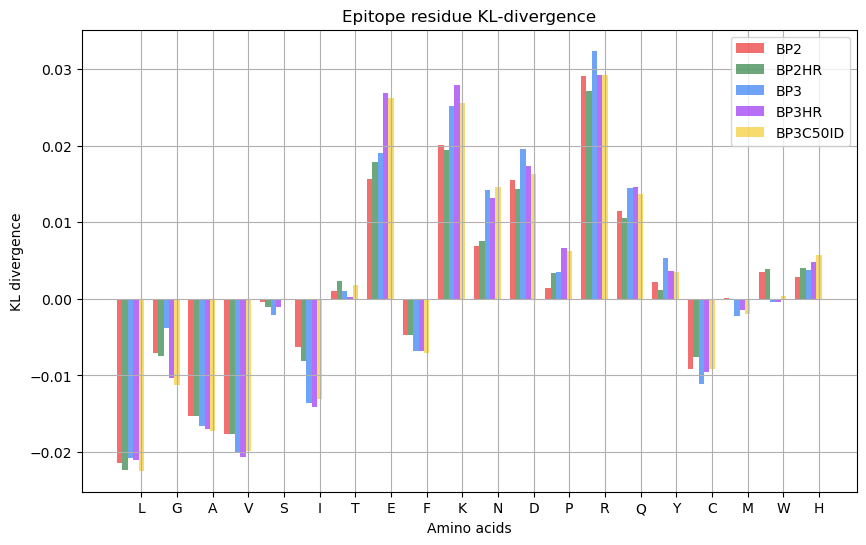

Average linear epitope length 4.091682419659735
Average linear epitope length 4.280805687203792
Average linear epitope length 3.718357651849338
Average linear epitope length 3.742128935532234
Average linear epitope length 3.7085792101679527
BP2 Total number of epitopes 2071
Epitope length and counts:  [(1, 1013), (2, 447), (3, 192), (4, 116), (5, 86), (6, 55), (7, 49), (8, 36), (9, 18), (10, 13), (11, 14), (12, 7), (13, 1), (14, 4), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 1), (22, 2), (23, 2), (24, 1), (25, 0), (28, 1), (31, 0), (32, 1)]
BP2HR Total number of epitopes 1644
Epitope length and counts:  [(1, 800), (2, 340), (3, 141), (4, 101), (5, 72), (6, 46), (7, 43), (8, 32), (9, 15), (10, 11), (11, 12), (12, 7), (13, 1), (14, 4), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 0), (28, 1), (31, 0), (32, 1)]
BP3 Total number of epitopes 6333
Epitope length and counts:  [(1, 3386), (2, 1232), (3, 598), (4, 365), (5, 237),

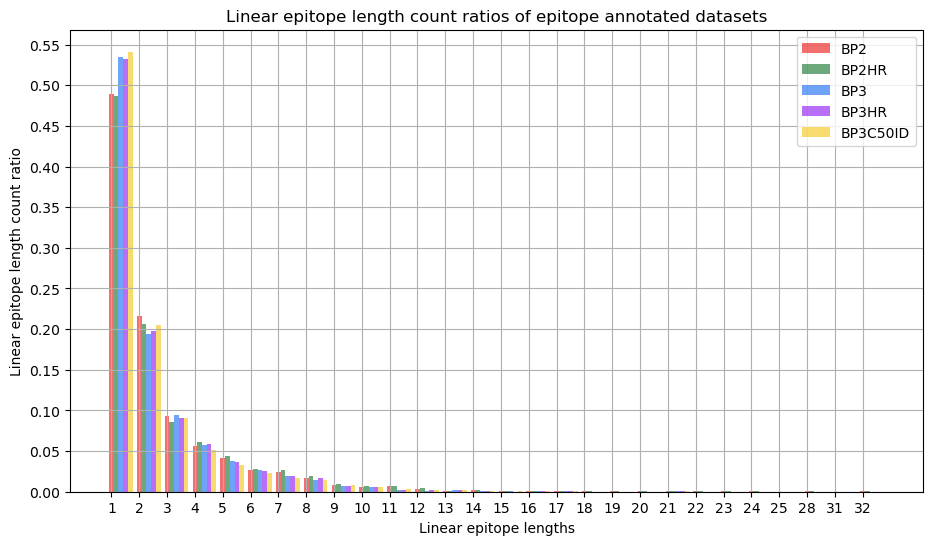

40
43
40
43
40
43
[40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
Save directory was already there. Saving it there.


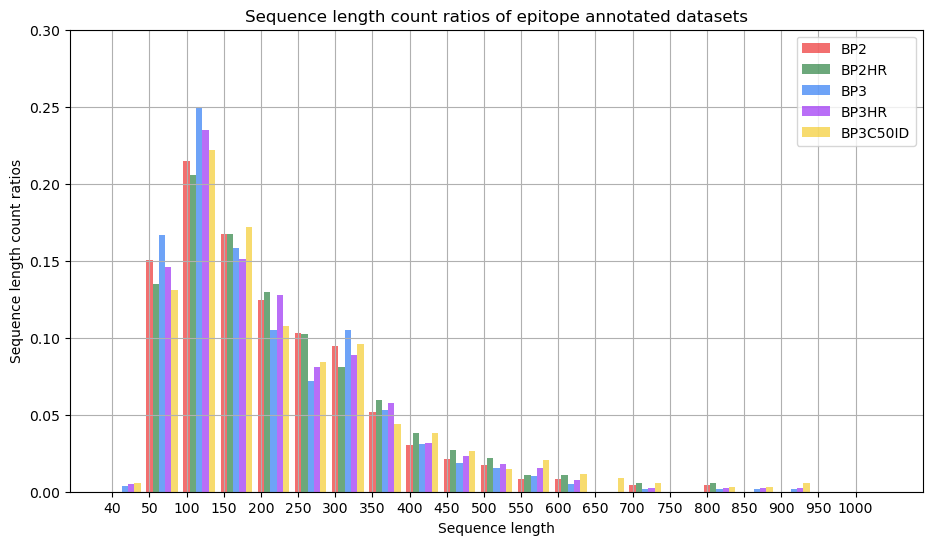

In [15]:
amino_acids = ['L', "G", "A", "V", "S", "I", "T", "E", "F", "K", "N", "D", "P", "R", "Q", "Y", "C", "M", "W", "H"]
bepipred2_training_and_validation_no_homology_reduction = BEPIPRED2_DATA / "1DatasetPreparation" / "3DivideProteinsInto5Partitions" / "Results" / "bepipred2_all_annotations.fasta"
bepipred2_training_and_validation_homology_reduction = BEPIPRED2_DATA / "1DatasetPreparation" / "2ClusterAt70Id" / "Id70ClusterResults" / "Id70ClusterRes_rep_seq.fasta"
bepipred3_training_and_validation_no_homology_reduction = bepipred3_anno_path = BEPIPRED3_DATA / "5DatasetPreparation" / "4DivideProteinsInto5Partitions" / "Results" / "bepipred3_all_annotations.fasta"
bepipred3_training_and_validation_homology_reduction = BEPIPRED3_DATA / "5DatasetPreparation" / "3ClusterAt70Id" / "Id70ClusterResults" / "Id70ClusterRes_rep_seq.fasta"
bepipred3_training_and_validation_Clus50ID = BEPIPRED3_DATA / "6Clusterat50ID" / "2CreateTestSet" / "bepipred3_test_set_removed.fasta"


aa_counts_bp2_no_hom_reduced, sequence_length_counts_bp2_no_hom_reduced, lin_epi_count_dict_bp2_no_hom_reduced = get_stats_from_fasta_file(bepipred2_training_and_validation_no_homology_reduction, amino_acids)
aa_counts_bp2_hom_reduced, sequence_length_counts_bp2_hom_reduced, lin_epi_count_dict_bp2_hom_reduced = get_stats_from_fasta_file(bepipred2_training_and_validation_homology_reduction, amino_acids)

aa_counts_bp3_no_hom_reduced, sequence_length_counts_bp3_no_hom_reduced, lin_epi_count_dict_bp3_no_hom_reduced = get_stats_from_fasta_file(bepipred3_training_and_validation_no_homology_reduction, amino_acids)
aa_counts_bp3_hom_reduced, sequence_length_counts_bp3_hom_reduced, lin_epi_count_dict_bp3_hom_reduced = get_stats_from_fasta_file(bepipred3_training_and_validation_homology_reduction, amino_acids)
aa_counts_bp3_Clus50ID, sequence_length_counts_bp3_Clus50ID, lin_epi_count_dict_bp3_Clus50ID = get_stats_from_fasta_file(bepipred3_training_and_validation_Clus50ID, amino_acids)


#lin_epi_count_dict_bp2_hom_reduced = barplot_epitope_aa_distribution_and_stats_from_fasta(bepipred2_training_and_validation_homology_reduction, amino_acids)

#lin_epi_count_dict_bp3_no_hom_reduced = barplot_epitope_aa_distribution_and_stats_from_fasta(bepipred3_training_and_validation_no_homology_reduction, amino_acids)
#lin_epi_count_dict_bp3_hom_reduced = barplot_epitope_aa_distribution_and_stats_from_fasta(bepipred3_training_and_validation_homology_reduction, amino_acids)
#lin_epi_count_dict_bp3_Clus50ID = barplot_epitope_aa_distribution_and_stats_from_fasta(bepipred3_training_and_validation_Clus50ID, amino_acids)

all_aa_counts = (aa_counts_bp2_no_hom_reduced, aa_counts_bp2_hom_reduced,
                aa_counts_bp3_no_hom_reduced, aa_counts_bp3_hom_reduced,
                aa_counts_bp3_Clus50ID)

all_sequence_length_count_dicts = (sequence_length_counts_bp2_no_hom_reduced, sequence_length_counts_bp2_hom_reduced,
                                   sequence_length_counts_bp3_no_hom_reduced, sequence_length_counts_bp3_hom_reduced,
                                   sequence_length_counts_bp3_Clus50ID)


all_lin_epi_count_dicts = (lin_epi_count_dict_bp2_no_hom_reduced, lin_epi_count_dict_bp2_hom_reduced,
                          lin_epi_count_dict_bp3_no_hom_reduced, lin_epi_count_dict_bp3_hom_reduced,
                          lin_epi_count_dict_bp3_Clus50ID)

epitope_aa_distribution_barplot(amino_acids, all_aa_counts, RESULTS_DIR / "DatasetStatistics" / "kl_divergence_epitope_ratios_barplot" )
combined_linear_epitope_length_barplot(all_lin_epi_count_dicts, RESULTS_DIR / "DatasetStatistics" / "linear_epitope_length_distribution_barplot")
sequence_length_barplot(all_sequence_length_count_dicts, RESULTS_DIR / "DatasetStatistics" / "sequence_length_distribution_barplot")

In [ ]:
### #TODO
#Get overall epitope frequency (DONE)
#Add text to each bar in plot (DONE)
#Create linear epitope bar plot (DONE)
#Average number of epitopes per sequence (DONE)
#Create sequence length barplot (DONE)

# Old Code

In [ ]:
#### IEDB Eval data ###

#read sequence and create sliding windows
#iedb_sequence_windows, aa_iedb_dataset_counts = sliding_windows_from_sequence(DATA_DIR / "RawData" / "iedb_linear_epitopes.fasta",
#                                                                      ignore_unknown_characters=("x", "z", "b", "j"))
#one_hot_encode data
#one_hot_encoded_sequences, labels = onehot_encode(iedb_sequence_windows, one_hot_encoding_dict)
#save iedb data
#save_data(one_hot_encoded_sequences, labels, "OneHotEncoding_padded", "iedb_eval")

In [14]:
np.asarray([[1,1], [1,3,4]], dtype=object)

array([list([1, 1]), list([1, 3, 4])], dtype=object)

In [53]:
test_labels = np.array([[1, 0, 1, 3, 4, "check"], [1, 0, 1, 3, "check"], [1, 0, 1, 3, "check"]], dtype=object)
test_labels, acc_names = np.asarray(test_labels[:][::-1], test_labels[:][-1] 

In [54]:
print(test_labels)

[list([1, 0, 1, 3, 'check']) list([1, 0, 1, 3, 'check'])
 list([1, 0, 1, 3, 4, 'check'])]


In [55]:
print(acc_names)

[1, 0, 1, 3, 'check']


In [11]:
test = [torch.rand((120,1280)), torch.rand((150,1280)), torch.rand((210,1280)) ]

In [12]:
print(test)

[tensor([[0.4581, 0.4829, 0.3125,  ..., 0.3078, 0.5619, 0.0045],
        [0.7131, 0.0930, 0.7798,  ..., 0.9980, 0.5881, 0.0541],
        [0.1102, 0.6142, 0.6766,  ..., 0.8217, 0.1244, 0.5393],
        ...,
        [0.5183, 0.6065, 0.6827,  ..., 0.4805, 0.0512, 0.3028],
        [0.4689, 0.8704, 0.4011,  ..., 0.0783, 0.4655, 0.2444],
        [0.3218, 0.8304, 0.5348,  ..., 0.8772, 0.2881, 0.0431]]), tensor([[0.3990, 0.5335, 0.8399,  ..., 0.7083, 0.7951, 0.4572],
        [0.8296, 0.6941, 0.5141,  ..., 0.0488, 0.4626, 0.0990],
        [0.0943, 0.6119, 0.4862,  ..., 0.6711, 0.2289, 0.6259],
        ...,
        [0.7272, 0.1527, 0.0683,  ..., 0.6240, 0.7782, 0.9954],
        [0.8440, 0.4604, 0.0668,  ..., 0.6088, 0.3009, 0.8322],
        [0.3563, 0.1830, 0.0812,  ..., 0.2167, 0.8349, 0.4285]]), tensor([[0.2363, 0.3991, 0.5337,  ..., 0.3200, 0.1829, 0.9678],
        [0.9951, 0.2422, 0.9584,  ..., 0.1464, 0.8210, 0.7235],
        [0.0754, 0.5491, 0.8572,  ..., 0.1135, 0.8973, 0.2553],
        .

In [13]:
testing = torch.cat(test)

In [14]:
print(testing.size())

torch.Size([480, 1280])


In [15]:
print(testing)

tensor([[0.4581, 0.4829, 0.3125,  ..., 0.3078, 0.5619, 0.0045],
        [0.7131, 0.0930, 0.7798,  ..., 0.9980, 0.5881, 0.0541],
        [0.1102, 0.6142, 0.6766,  ..., 0.8217, 0.1244, 0.5393],
        ...,
        [0.6091, 0.9535, 0.8352,  ..., 0.9005, 0.2171, 0.6465],
        [0.7471, 0.5440, 0.0798,  ..., 0.8146, 0.3962, 0.6816],
        [0.6579, 0.7708, 0.0280,  ..., 0.1733, 0.4015, 0.3602]])


In [128]:
set([2,2,2])

{2}

# OLD

In [ ]:
#def sliding_windows_from_sequence(infile_path, window_size = 9, ignore_unknown_characters = None):
#    """
#    Inputs: infile_path. A fasta file containing sequences with B-cell and non B-cell epitopes.
#    Outputs: List. Dimensions: ( number_of_seqs*(seq_len - window_size + 1), window_size)
#    """
#    #get binary sequence indices
#    infile = open(infile_path, 'rb')
#    whole_file = infile.read()
#    seq_start_ends = get_seq_indexes(whole_file)
#    all_sequences = ""
#    seq_windows = list()
#    
#    #go through each sequence and create all window_sized sequences
#    for seq_start_end in seq_start_ends:
#        seq_start = seq_start_end[0]
#        seq_end = seq_start_end[1]
#        start_read = infile.seek(seq_start)
#       
#        input_sequence = infile.read(seq_end - seq_start).decode("utf-8")
#        #used to remove unknown characters from iedb dataset which are not in training dataset
#        if ignore_unknown_characters != None:
#    
#            if any(res in input_sequence for res in ignore_unknown_characters):
#                continue
#            
#            else:
#                #add padding
#                padding = "".join(["-" for i in range(int(window_size / 2))])
#                padded_sequence = padding + input_sequence + padding
#                seq_len = len(padded_sequence)
#            
#                for i in range(seq_len - window_size + 1):
#                    window = padded_sequence[i:i + window_size]
#                    seq_windows.append(window)                    
#        else:
#            #add padding
#            padding = "".join(["-" for i in range(int(window_size / 2))])
#            padded_sequence = padding + input_sequence + padding
#            seq_len = len(padded_sequence)
#            for i in range(seq_len - window_size + 1):
#                window = padded_sequence[i:i + window_size]
#                seq_windows.append(window)
#    
#    
#    #close file
#    infile.close()
#
#    return seq_windows



    
#def onehot_encode(seqs, one_hot_encoding_dict):
#    """
#    Inputs: Sequences. List of strings.
#            one_hot_encoding_dict. Dictionary contanining the values that values should be mapped to. 
#    
#    Outputs: Numpy array. one_hot_encoded_sequences with dimension. Dimensions: Dimensions: (Sequences, sequence length, 20)
#             Numpy array. labels. Labels are 1 = Epitope and 0 = Non-epitope. Dimensions: (Sequences)
#   """
#    
#    
#    num_of_seqs = len(seqs)
#    seq_lens = len(seqs[0])
#    encoding_len = len(one_hot_encoding_dict)
#    seq_middle = int(seq_lens / 2)
#    idx_count = 0
#    one_hot_encoded_sequences = np.zeros( (num_of_seqs*2, seq_lens, encoding_len), dtype= np.uint8 )    
#    labels = np.zeros(num_of_seqs*2, dtype= np.uint8)
#   
#    for seq in seqs:
#        one_hot_encoded_sequence = np.zeros( (seq_lens, encoding_len) )
#        
#        for i in range( seq_lens ):
#            one_hot_encoded_sequence[i , one_hot_encoding_dict[seq[i].upper()]] = 1
#       
#        #if AA is part of an epitope
#        if seq[seq_middle] in "ACMNDPEFQRGHIKLSTVWY":
#            labels[idx_count] = 1 
#            labels[idx_count + 1] = 1
#        
#        #if AA is not part of an epitope
#        elif seq[seq_middle] in "acmndpefqrghiklstvwy":
#            labels[idx_count] = 0 
#            labels[idx_count + 1] = 0
#        else:
#            print(f"Found unrecognized AA: {seq[i][seq_middle]}")
#       
#        #append both non-inverted sequence and inverted sequence
#        one_hot_encoded_sequences[idx_count] = one_hot_encoded_sequence
#        one_hot_encoded_sequences[idx_count + 1] = np.flip(one_hot_encoded_sequence, axis=0)
#        
#        idx_count += 2
#   
#    return one_hot_encoded_sequences, labels
#


#def save_data(X, y, save_dirname, filename = "foo"):
#    
#    try:
#        save_dirname.mkdir(parents=True, exist_ok=False)
#    except FileExistsError:
#        print("Save directory was already there. Saving data there.")
#    else:
#        print("Save directory not found. Made new one. ")
#    
#    save_path = save_dirname / filename
#    np.savez_compressed(save_path, saved_X = X, saved_y = y)
#    
#
#def data_to_fasta_format(pdb_accs, outfile_path, filename = "foo"):
#    """
#    Inputs: pdb_accs: List of tuples, consisting of accesions and sequences [(accs, ATGRE..)..]
#    Outputs: Fasta file at outfile_path
#    """
#    outfile_path = Path(outfile_path)
#    try:
#        outfile_path.mkdir(parents=True, exist_ok=False)
#    except FileExistsError:
#        print("Save directory was already there. Saving data there.")
#    else:
#        print("Save directory not found. Made new one. ")
#        
#    with open(outfile_path / filename, "w") as outfile:
#        output = str()
#        for pdb_acc in pdb_accs:
#            output += f">{pdb_acc[0]}\n{pdb_acc[1]}\n"#

#        output = output[:-1]
#        outfile.write(output)
#    
#    
#def get_epitope_labels_as_binary_array_from_sequence(sequence):
#    """
#    Input: sequence: String. Amino acid sequence where epitope are marked with capitilized letters. 
#    Outputs: binary_epitope_annotated_array: Np array. Binary array where 0 = Non-epitope and 1 = Epitope. 
#    """
#    
#    seq_len = len(sequence)
#    binary_epitope_annotated_array = np.zeros(seq_len, dtype= np.uint8)
#    for i in range (seq_len):
#        #if it is an epitope
#        if sequence[i].isupper():
#            binary_epitope_annotated_array[i] = 1
#        #if it is not an epitope
#        elif sequence[i].islower():
#            binary_epitope_annotated_array[i] = 0
#        #if something else, it's weird.
#        else:
#            print(f"Something weird in sequence detected: {sequence[i]}")
#            break
#    
#    return binary_epitope_annotated_array
#        
#def get_epitope_labels_as_binary_array_from_fasta(fasta_file_path):
#    """
#    Inputs: fasta_file_path: Valid fasta file path containing antigens where eptiope are annotated with capitlized letters.
#    Outputs: binary_epitope_annotated_arrays: Dict, containing accesions and binarized epitope annotation, e.g.
#             {acc:00011110, acc1:01001010,}
#    
#    """
#    
#    fasta_file_path = Path(fasta_file_path)
#    if not fasta_file_path.is_file():
#        sys.exit(f"Invalid fasta file given. Fasta file given: {fasta_file_path}")
#        
#    pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(fasta_file_path)
#    binary_epitope_annotated_arrays = dict()
#    
#    for pdb_acc_and_sequence in pdb_accs_and_sequences:
#        pdb_acc = pdb_acc_and_sequence[0]
#        pdb_sequence = pdb_acc_and_sequence[1]
#        binary_epitope_annotated_array = get_epitope_labels_as_binary_array_from_sequence(pdb_sequence)
#        binary_epitope_annotated_arrays[pdb_acc] = binary_epitope_annotated_array
#    
#    return binary_epitope_annotated_arrays
#             
#def create_annotation_removed_pdb_accs(readfile):
#    """
#    Inputs: readfile: Valid fasta file path containing antigens
#                      where eptiope are annotated with capitlized letters.         
#    Outputs: not_annotated_pdb_accs: List of tuples, containing accesions and non-annotated seuqences e.g. [(acc, ATAGAH..)..()]  
#    """
#    
#    not_annotated_pdb_accs_and_sequences = list()
#    pdb_accs_and_sequences = read_accs_and_sequences_from_fasta(readfile)
#    
#    #convert all sequences to uppercase
#    for pdb_acc_and_sequence in pdb_accs_and_sequences:
#        pdb_acc = pdb_acc_and_sequence[0]
#        pdb_sequence = pdb_acc_and_sequence[1].upper()
#        not_annotated_pdb_accs_and_sequences.append( (pdb_acc, pdb_sequence) ) 
#    
#    return not_annotated_pdb_accs_and_sequences
# 
#def crossvalidation_folds(X, y, num_of_folds, save_dirname, esm_encoded_data = False):
#    """
#    Inputs: 
#        X: Dataset of sequences.
#        y: labels
#        num_of_fold: Number crossvalidation folds
#        save_dirname: save directory
#    Slightly different method for when encoding esm data vs. one_hot_encoded data. 
#    """
#    
#    try:
#        save_dirname.mkdir(parents=True, exist_ok=False)
#    except FileExistsError:
#        print("Save directory was already there. Saving data there.")
#    else:
#        print("Save directory not found. Made new one. ")
#    
#    #cross validation setup
#    Folds = 1
#    kf = KFold(n_splits=num_of_folds)
#    kf.get_n_splits(X, y)   
#    for train_index, val_index in kf.split(X):
#        fold_path = save_dirname / f"Fold{Folds}"
#        X_train, X_val = X[train_index], X[val_index]
#        y_train, y_val = y[train_index], y[val_index]
#
#            
#        np.savez_compressed(fold_path, saved_X_train=X_train, saved_X_val=X_val,
#                            saved_y_train=y_train, saved_y_val=y_val)
#        #save one-hot-encoded data
#        if not esm_encoded_data:
#            num_epitopes = len([pos for pos in y_train if pos == 1]) 
#            num_non_epitopes = len([pos for pos in y_train if pos == 0])
#            print(f"Training dataset epitope and non-epitope residues: {num_epitopes} and {num_non_epitopes}")
#        
#            num_epitopes = len([pos for pos in y_val if pos == 1]) 
#            num_non_epitopes = len([pos for pos in y_val if pos == 0])
#            print(f"Validation dataset epitope and non-epitope residues: {num_epitopes} and {num_non_epitopes}")
#        
#        Folds += 1
#
#def get_esm_representations_and_labels(esm_encoded_data_path, antigen_with_epitopes_path):
#    
#    all_binary_labels = list()
#    all_esm_representations = list()
#    #get labels from annotated data
#    binary_annotations = get_epitope_labels_as_binary_array_from_fasta(antigen_with_epitopes_path)
#    esm_encoded_acc_paths = list( esm_encoded_data_path.glob("*.pt") )
#    for esm_encoded_acc_path in esm_encoded_acc_paths:
#        esm_encoded_acc = torch.load(esm_encoded_acc_path)
#        acc = esm_encoded_acc["label"]
#        #33 is a dict key they use in the esm representations
#        esm_representations = esm_encoded_acc["representations"][33]
#        #add accesion into labeling for now, so protein names can be retrieved after crossvalidation shuffling.
#        binary_labels = np.append(binary_annotations[acc], acc)
#        all_binary_labels.append(binary_labels)
#        all_esm_representations.append(esm_representations)
#        
#    return all_esm_representations, all_binary_labels
#
#
#
#def esm_cv_dataset_creation_wrapper(esm_encoded_path, antigens_with_epitopes_path, save_path, test_data = False):
#    
#    all_esm_representations, all_binary_labels = get_esm_representations_and_labels(esm_encoded_path,
#                                                                                    antigens_with_epitopes_path)
#    
#    all_esm_representations = np.asarray(all_esm_representations, dtype=object)
#    all_binary_labels = np.asarray(all_binary_labels, dtype=object)
#    
#    if test_data:
#        save_data(all_esm_representations, all_binary_labels, save_path, "test")    
#    else:        
#        crossvalidation_folds(all_esm_representations, all_binary_labels, 5,
#                              save_path, esm_encoded_data = True)
#    
#
#
#

### BEPIPRED2 DATA ###
###read sequence and create sliding windows
#sequence_windows = sliding_windows_from_sequence(DATA_DIR / "BepiPred2Data" / "pdb_chains.fasta")
###one_hot_encode data
#one_hot_encoded_sequences, labels = onehot_encode(sequence_windows, one_hot_encoding_dict)
#print(one_hot_encoded_sequences)
###shuffle the data
#one_hot_encoded_sequences, labels = shuffle(one_hot_encoded_sequences, labels) 
####create crossvalidation setups
##save_data(one_hot_encoded_sequences, labels, DATASET_DIR / "BepiPred2OneHotEncoding", "NoCv")
##crossvalidation_folds(one_hot_encoded_sequences, labels, 5, DATASET_DIR / "BepiPred2OneHotEncoding")
##
##### BEPIPRED2 DATA Clustered ###
###read sequence and create sliding windows
##sequence_windows = sliding_windows_from_sequence(DATA_DIR / "BepiPred2Data" / "HomologyClustering" / "clustered_combined_antigens.fasta")
####one_hot_encode data
##one_hot_encoded_sequences, labels = onehot_encode(sequence_windows, one_hot_encoding_dict)
####shuffle the data
##one_hot_encoded_sequences, labels = shuffle(one_hot_encoded_sequences, labels) 
####create crossvalidation setups
##save_data(one_hot_encoded_sequences, labels, DATASET_DIR / "BepiPred2OneHotEncodingClustered", "NoCv")
##crossvalidation_folds(one_hot_encoded_sequences, labels, 5, DATASET_DIR / "BepiPred2OneHotEncodingClustered")
##
##### BEPIPRED2 Test/Eval ###
##test_sequence_windows = sliding_windows_from_sequence(DATA_DIR / "BepiPred2Data" / "eval_pdb_chains.fasta" )
##one_hot_encoded_sequences, labels = onehot_encode(test_sequence_windows, one_hot_encoding_dict)
##save_data(one_hot_encoded_sequences, labels, DATASET_DIR / "BepiPred2TestOneHotEncoding", "test")
##
####### BEPIPRED3 DATA ###
####read sequence and create sliding windows
##sequence_windows = sliding_windows_from_sequence(DATA_DIR / "BepiPred3Data" / "bepipred3_antigens.fasta")
####one_hot_encode data
##one_hot_encoded_sequences, labels = onehot_encode(sequence_windows, one_hot_encoding_dict)
####shuffle the data
##one_hot_encoded_sequences, labels = shuffle(one_hot_encoded_sequences, labels) 
####create crossvalidation setups
##save_data(one_hot_encoded_sequences, labels, DATASET_DIR / "BepiPred3OneHotEncoding", "NoCv")
##crossvalidation_folds(one_hot_encoded_sequences, labels, 5, DATASET_DIR / "BepiPred3OneHotEncoding")
##
##### BEPIPRED 3 DATA Clustered  ###
###read sequence and create sliding windows
##sequence_windows = sliding_windows_from_sequence(DATA_DIR / "BepiPred3Data" / "bepipred3_clustered_antigens.fasta")
####one_hot_encode data
##one_hot_encoded_sequences, labels = onehot_encode(sequence_windows, one_hot_encoding_dict)
####shuffle the data
##one_hot_encoded_sequences, labels = shuffle(one_hot_encoded_sequences, labels) 
####create crossvalidation setups
##save_data(one_hot_encoded_sequences, labels, DATASET_DIR / "BepiPred3OneHotEncodingClustered", "NoCv")
##crossvalidation_folds(one_hot_encoded_sequences, labels, 5, DATASET_DIR / "BepiPred3OneHotEncodingClustered")
##
##### BEPIPRED 3 Test/Eval ###
##test_sequence_windows = sliding_windows_from_sequence(DATA_DIR / "BepiPred3Data" / "bepipred3_eval_chains.fasta" )
#one_hot_encoded_sequences, labels = onehot_encode(test_sequence_windows, one_hot_encoding_dict)
#save_data(one_hot_encoded_sequences, labels, DATASET_DIR / "BepiPred3TestOneHotEncoding", "test")


### Read epitope annotaed antigen fasta files ###

#BepiPred2
#not_annotated_bepipred2_data = create_annotation_removed_pdb_accs(DATA_DIR / "BepiPred2Data" / "pdb_chains.fasta")
#not_annotated_clustered_bepipred2_data = create_annotation_removed_pdb_accs(DATA_DIR / "BepiPred2Data" / "HomologyClustering" / "clustered_combined_antigens.fasta") 
#not_annotated_bepipred2_test_data = create_annotation_removed_pdb_accs(DATA_DIR / "BepiPred2Data" / "eval_pdb_chains.fasta")

#save data
#data_to_fasta_format(not_annotated_bepipred2_data,
#                     DATA_DIR / "BepiPred2Data", "not_annotated_pdb_chains.fasta")
#data_to_fasta_format(not_annotated_clustered_bepipred2_data,
#                     DATA_DIR / "BepiPred2Data", "not_annotated_clustered_pdb_chains.fasta")
#data_to_fasta_format(not_annotated_bepipred2_test_data,
#                     DATA_DIR / "BepiPred2Data", "not_annotated_eval_pdb_chains.fasta")

#BepiPred3
#not_annotated_bepipred3_data = create_annotation_removed_pdb_accs(DATA_DIR / "BepiPred3Data" / "bepipred3_antigens.fasta")
#not_annotated_bepipred3_clustered_data = create_annotation_removed_pdb_accs(DATA_DIR / "BepiPred3Data / "bepipred3_clustered_antigens.fasta")
#not_annotated_bepipred3_test_data = create_annotation_removed_pdb_accs(DATA_DIR / "BepiPred3Data" / "bepipred3_eval_chains.fasta")

#save data
#data_to_fasta_format(not_annotated_bepipred3_data,
#                     DATA_DIR / ""BepiPred3Data"", "not_annotated_bepipred3_antigens.fasta")
#data_to_fasta_format(not_annotated_bepipred3_clustered_data,
 #                    DATA_DIR / ""BepiPred3Data"", "not_annotated_bepipred3_clustered_antigens.fasta")                                                             
#data_to_fasta_format(not_annotated_bepipred3_test_data,
#                     DATA_DIR / "BepiPred3Data",  "not_annotated_bepipred3_eval_chains.fasta")

##### BEPIPRED2 DATA ###
#esm_cv_dataset_creation_wrapper(DATA_DIR / "BepiPred2Data" / "ESMEncoded",
#                                 DATA_DIR / "BepiPred2Data" / "pdb_chains.fasta",
#                               DATASET_DIR / "BepiPred2DataESMEncoded")
##### BEPIPRED2 DATA CLUSTERED ###
#sm_cv_dataset_creation_wrapper(DATA_DIR / "BepiPred2Data" / "ESMEncodedClustered",
#                                DATA_DIR / "BepiPred2Data" / "HomologyClustering" / "clustered_combined_antigens.fasta",
#                              DATASET_DIR / "BepiPred2ESMEncodedClustered")
#
#bepipred2 test/eval
#esm_cv_dataset_creation_wrapper(DATA_DIR / "BepiPred2Data" / "TestEvalESMEncoded",
#                                 DATA_DIR / "BepiPred2Data" / "eval_pdb_chains.fasta",
#                               DATASET_DIR / "BepiPred2TestESMEncoded",
#                               test_data=True)
#
###### BEPIPRED3 DATA ###
#esm_cv_dataset_creation_wrapper(DATA_DIR / "BepiPred3Data" / "ESMEncoded",
#                                DATA_DIR / "BepiPred3Data" / "bepipred3_antigens.fasta",
#                              DATASET_DIR / "BepiPred3ESMEncoded")
#
### BEPIPRED3 DATA CLUSTERED ###
#esm_cv_dataset_creation_wrapper(DATA_DIR / "BepiPred3Data" / "ESMEncodedClustered",
#                                 DATA_DIR / "BepiPred3Data" / "bepipred3_clustered_antigens.fasta",
#                               DATASET_DIR / "BepiPred3ESMEncodedClustered")
#
#esm_cv_dataset_creation_wrapper(DATA_DIR / "BepiPred3Data" / "TestEvalESMEncoded",
#                                 DATA_DIR / "BepiPred3Data" / "bepipred3_eval_chains.fasta",
#                                DATASET_DIR / "BepiPred3TestESMEncoded",
#                               test_data=True)

#### New BEPIPRED3 CLUSTERED REPRESENTATIVES at 70ID ###
#esm_cv_dataset_creation_wrapper(DATA_DIR / "BepiPred3Data" / "ClusterId70Rep",
#                                 DATASET_DIR / "7CrossValidation" / "bepipred3_all_annotations.fasta",
#                               DATASET_DIR / "7CrossValidationId70Rep")


In [21]:
colors = [( (234, 15, 15), (234, 97, 15) ),
              ((10, 110, 36 ), (10, 197, 60)),
             ((13, 102, 242), (13, 230, 242)),
             ((139, 13, 242), (242, 13, 235)),
             ((242, 196, 13 ), (242, 231, 13))]

In [23]:
colors[0][1]

(234, 97, 15)

In [4]:
arr = np.asarray([[0.128,0.134,0.144,0.107,0.354,0.147,0.130,0.060,0.069,0.339,0.178,0.048,0.079,0.189,0.264],
                 [0.167,0.186,0.170,0.172,0.148,0.071,0.258,0.107,0.120,0.216,0.219,0.051,0.113,0.114,0.265],
                 [0.178, 0.195,0.183,0.195,0.310,0.073,0.111,0.086,0.078,0.328,0.218,0.039,0.138,0.240, 0.291],
                 [0.129,0.207,0.174,0.195,0.300,0.069,0.222,0.094,0.123,0.269,0.248,0.070,0.130,0.123, 0.295],
                 [0.166,0.220,0.149,0.185,0.336,0.087,0.257,0.103,0.063,0.358,0.186,0.058,0.121,0.213,0.231],
                 [0.163,0.187,0.173,0.159,0.295,0.081,0.259,0.074,0.070,0.298,0.220,0.062,0.128,0.168,0.257]])


arrBP3 = np.asarray([[0.604, 0.096, 0.074, 0.356, 0.236, 0.284, 0.658],
[0.604, 0.088, 0.072, 0.324, 0.237, 0.274, 0.674],
[0.617, 0.108, 0.132, 0.564, 0.250, 0.346, 0.595],
[0.637, 0.109, 0.163, 0.620, 0.260, 0.366, 0.593],
[0.677, 0.116, 0.184, 0.610, 0.275, 0.379, 0.620],
[0.629, 0.104, 0.145, 0.577, 0.255, 0.354, 0.600],
[0.629, 0.070, 0.157, 0.618, 0.257, 0.363, 0.588],
[0.664, 0.102, 0.180, 0.535, 0.284, 0.371, 0.656],
[0.609, 0.087, 0.113, 0.634, 0.233, 0.340, 0.534],
[0.635, 0.101, 0.149, 0.677, 0.245, 0.360, 0.543],
[0.652, 0.103, 0.165, 0.551, 0.272, 0.364, 0.634]])


arrBP3Clus50ID = np.asarray([[0.593, 0.091, 0.104, 0.535, 0.237, 0.328, 0.585],
[0.611, 0.096, 0.129, 0.593, 0.245, 0.347, 0.576],
[0.631, 0.104, 0.153, 0.716, 0.243, 0.363, 0.522],
[0.630, 0.103, 0.155, 0.730, 0.243, 0.364, 0.516],
[0.697, 0.118, 0.220, 0.658, 0.289, 0.401, 0.627],
[0.635, 0.101, 0.154, 0.746, 0.240, 0.364, 0.504],
[0.636, 0.101, 0.158, 0.723, 0.245, 0.366, 0.523],
[0.685, 0.115, 0.205, 0.585, 0.293, 0.390, 0.653],
[0.606, 0.092, 0.113, 0.732, 0.225, 0.344, 0.469],
[0.641, 0.103, 0.147, 0.542, 0.261, 0.353, 0.622],
[0.685, 0.116, 0.214, 0.596, 0.297, 0.396, 0.655]])







In [11]:
print(np.mean(arrBP3, axis=0))
print(np.mean(arrBP3Clus50ID, axis=0))

[0.63245455 0.09854545 0.13945455 0.55145455 0.25490909 0.34554545
 0.60863636]
[0.64090909 0.10363636 0.15927273 0.65054545 0.25618182 0.36509091
 0.56836364]


In [93]:
bin_list = np.arange(50, 1201, 50) 

In [94]:
print(bin_list)

[  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000 1050 1100 1150 1200]
